# Implementing a Binary, Three-Layer NN in PyTorch

Names and partners:

Ben Berry and Cole Determan

First we'll create a dataset that is non-linearly seperable, and thus requires a hidden layer.

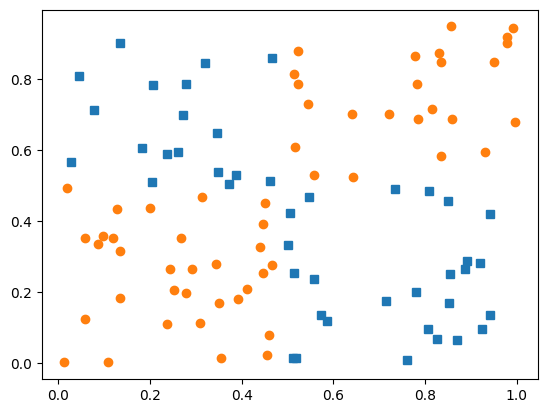

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt


def noisy_xor(num_points):
    """Synthetic 2d Dataset that is not linearly separable."""
    features = np.random.randint(2, size=(num_points, 2))
    labels = np.array(np.logical_xor(features[:, 0], features[:, 1]), dtype=np.float32)
    labels = np.expand_dims(labels, 1)
    features = np.array(
        (features + (np.random.random(features.shape))) / 2.0,
        dtype=np.float32,
    )
    return features, labels


train_size = 100
X, y = noisy_xor(train_size)

# Plot the dataset
plt.plot(X[y[:, 0] == 1, 0], X[y[:, 0] == 1, 1], "s")
plt.plot(X[y[:, 0] == 0, 0], X[y[:, 0] == 0, 1], "o")
plt.show()

# Convert to tensors
X = torch.tensor(X)
y = torch.tensor(y)


## Neural Network Review

Note: This cell may not be viewable in dark mode!

Recall our illustration of a simple three-layer neural network:

![Three Layer Network](nn_three.svg)

The activation at the hidden layer can be expressed as:

$h(\mathbf{x}^\textsf{T} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})$

In this example $h$ is the elementwise nonlinear function applied at the hidden layer, $\mathbf{W}^{(1)}$ is a $4\times 5$ weight matrix and $\mathbf{b}^{(1)}$ is a $1\times 5$ row vector containing the bias weights. (The bias weights are not shown in the image.)

The final output of the network can be expressed as follows:

$\sigma\left( \color{gray} h(\mathbf{x}^\textsf{T} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})\color{black} \mathbf{W}^{(2)} + b^{(2)}\right)$

Where $\sigma$ is the logistic function, $\mathbf{W}^{(2)}$ is a $5\times 1$ weight matrix and $\mathbf{b}^{(2)}$ is a scalar representing the bias weight of the output unit.

Here are some utility functions for calculating the two non-linearities and the cross-entropy loss:


In [2]:
def binary_cross_entropy_loss(pred, labels):
    return -torch.sum(labels * torch.log(pred) + (1.0 - labels) * torch.log(1.0 - pred))


def logistic(a):
    return 1.0 / (1.0 + torch.exp(-a))


def relu(a):
    return torch.max(a, torch.zeros_like(a))

In [3]:
# NOW CREATE THE PARAMETERS FOR OUR NETWORK
num_hidden = 10
W1 = torch.randn((2, num_hidden), requires_grad=True)
b1 = torch.randn((num_hidden,), requires_grad=True)
W2 = torch.randn((num_hidden, 1), requires_grad=True)
b2 = torch.randn((1,), requires_grad=True)

params = [W1, b1, W2, b2]

## Neural Network Implementation

In the cell below, complete the unfinished `forward` function and add code to train the resulting network.  Some advice:
* I suggest a nested training loop, where the out loop iterates over the epochs, and the inner loop iterates over the individual samples. For this simple implementation we'll perform a weight update after each sample. It is best practice to shuffle the data each epoch, but don't worry about that here.
* Start with a learning rate around .01
* It may take several hundred epochs to find a good fit.
* You may want a helper method named someing like `opt` or `sgd` that will take the list of parameters and update them based on their gradients.
* Don't forget to `.zero_()` the gradients after each udpate.


In [4]:
# This will sometimes converge at a low accuracy and I don't know why.
# When it fails it seems to just draw 2 diagonal lines to split the boundaries.
def forward(x, W1, b1, W2, b2):
    """Complete a forward pass through the network for input x."""
    hidden_activation = relu(torch.matmul(x, W1) + b1)
    output = logistic(torch.matmul(hidden_activation, W2) + b2)
    return output
epochs = 400
learning_rate = 0.01

def sgd(params, lr):
    """
    Performs a single SGD update step for all parameters in a list.
    """
    with torch.no_grad():
        for p in params:
            p -= lr * p.grad
            p.grad.zero_()

for epoch in range(epochs):
    for i in range(X.shape[0]):
        x_sample = X[i, :]
        y_label = y[i, :]
        prediction = forward(x_sample, W1, b1, W2, b2)
        loss = binary_cross_entropy_loss(prediction, y_label)
        loss.backward()
        sgd(params, learning_rate)
    if (epoch + 1) % 50 == 0:
        with torch.no_grad():
            total_loss = 0
            for i in range(X.shape[0]):
                pred = forward(X[i, :], W1, b1, W2, b2)
                total_loss += binary_cross_entropy_loss(pred, y[i, :])
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss.item():.4f}")

Epoch 50/400, Loss: 47.0585
Epoch 100/400, Loss: 30.9572
Epoch 150/400, Loss: 23.9897
Epoch 200/400, Loss: 20.2602
Epoch 250/400, Loss: 17.8473
Epoch 300/400, Loss: 16.2487
Epoch 350/400, Loss: 14.7025
Epoch 400/400, Loss: 13.4639


In [5]:
# Testing Code

test_size = 1000
X_test, y_test = noisy_xor(test_size)
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)

correct = 0
for i in range(test_size):
    if torch.round(y_test[i, 0]) == torch.round(forward(X_test[i, :], W1, b1, W2, b2)):
        correct += 1

print("ACCURACY", correct / test_size)
assert correct / test_size > .9

ACCURACY 0.952


## Visualize the Decision Boundary

Once you are satisfied with your results, execute the following cell to visualize the decision boundary learned by your network.

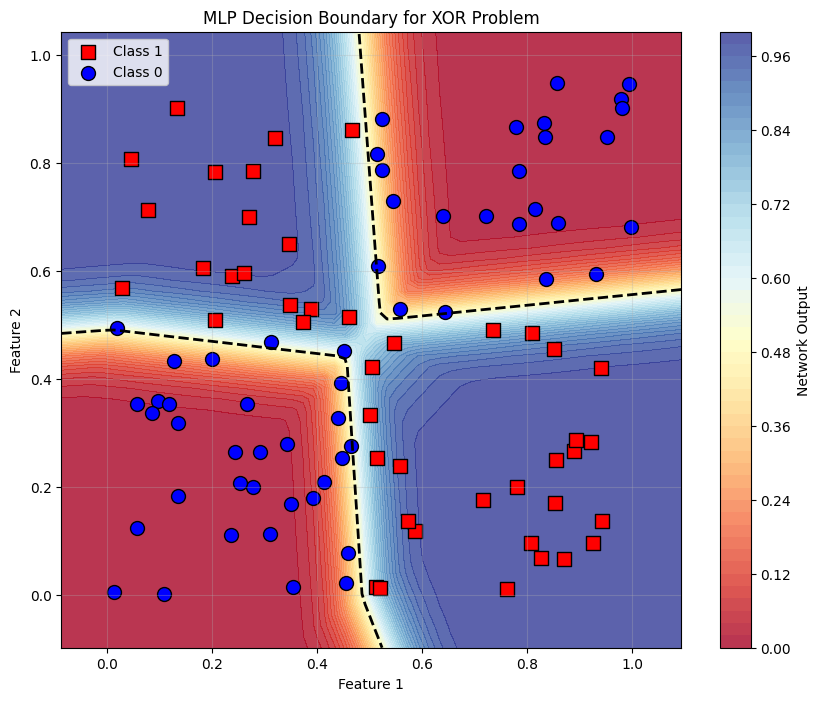

In [6]:
# Visualize the decision boundary (Code Produced by Claude Sonnet 4)

def plot_decision_boundary(X, y, W1, b1, W2, b2):
    """Plot the decision boundary learned by the network."""
    # Create a mesh grid
    h = 0.02  # step size in the mesh
    x_min, x_max = X[:, 0].min().item() - 0.1, X[:, 0].max().item() + 0.1
    y_min, y_max = X[:, 1].min().item() - 0.1, X[:, 1].max().item() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Make predictions on the mesh grid
    grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    with torch.no_grad():
        Z = []
        for point in grid_points:
            pred = forward(point, W1, b1, W2, b2)
            Z.append(pred.item())
        Z = np.array(Z)
    
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, levels=50, alpha=0.8, cmap=plt.cm.RdYlBu)
    plt.colorbar(label='Network Output')
    
    # Plot the training data
    plt.scatter(X[y[:, 0] == 1, 0], X[y[:, 0] == 1, 1], c='red', marker='s', s=100, edgecolors='black', label='Class 1')
    plt.scatter(X[y[:, 0] == 0, 0], X[y[:, 0] == 0, 1], c='blue', marker='o', s=100, edgecolors='black', label='Class 0')
    
    # Add decision boundary contour
    plt.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='--', linewidths=2)
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('MLP Decision Boundary for XOR Problem')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot the decision boundary
plot_decision_boundary(X, y, W1, b1, W2, b2)